# **Behavioral Cloning** 

## Writeup Template

### You can use this file as a template for your writeup if you want to submit it as a markdown file, but feel free to use some other method and submit a pdf if you prefer.

---

**Behavioral Cloning Project**

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report


[//]: # (Image References)

[image1]: ./examples/placeholder.png "Model Visualization"
[image2]: ./examples/placeholder.png "Grayscaling"
[image3]: ./examples/placeholder_small.png "Recovery Image"
[image4]: ./examples/placeholder_small.png "Recovery Image"
[image5]: ./examples/placeholder_small.png "Recovery Image"
[image6]: ./examples/placeholder_small.png "Normal Image"
[image7]: ./examples/placeholder_small.png "Flipped Image"

## Rubric Points
### Here I will consider the [rubric points](https://review.udacity.com/#!/rubrics/432/view) individually and describe how I addressed each point in my implementation.  

---
### Files Submitted & Code Quality

#### 1. Submission includes all required files and can be used to run the simulator in autonomous mode

My project includes the following files:
* model.py containing the script to create and train the model
* drive.py for driving the car in autonomous mode
* model.h5 containing a trained convolution neural network 
* writeup_report.md summarizing the results

#### 2. Submission includes functional code
Using the Udacity provided simulator and my drive.py file, the car can be driven autonomously around the track by executing 
```sh
python drive.py model.h5
```

#### 3. Submission code is usable and readable

The model.py file contains the code for training and saving the convolution neural network. The file shows the pipeline I used for training and validating the model, and it contains comments to explain how the code works.

### Model Architecture and Training Strategy

#### 1. An appropriate model architecture has been employed

I slightly modify the [nVIDIA model](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf), resulting the following structure:

| Layer (type) | Output Shape | Param # |
|:----|:----|:----|
|lambda_1 (Lambda)   | (None, 66, 200, 3)  | 0      |
|conv1 (Conv2D)      | (None, 33, 100, 24) | 1824   |
|conv2 (Conv2D)      | (None, 17, 50, 36)  | 21636  |
|conv3 (Conv2D)      | (None, 7, 23, 48)   | 43248  |
|conv4 (Conv2D)      | (None, 5, 21, 64)   | 27712  |
|conv5 (Conv2D)      | (None, 3, 19, 64)   | 36928  |
|conv6 (Conv2D)      | (None, 1, 17, 80)   | 46160  |
|flatten_1 (Flatten) | (None, 1360)        | 0      |
|dropout_1 (Dropout) | (None, 1360)        | 0      |
|fc1 (Dense)         | (None, 100)         | 136100 |
|fc2 (Dense)         | (None, 50)          | 5050   |
|fc3 (Dense)         | (None, 10)          | 510    |
|out (Dense)         | (None, 1)           | 11     |
There are 319179 parameters in total.

The differences from the original nVIDIA model are
1. Instead of using valid padding in layers conv1 and conv2, I use same padding.
2. To reduce the parameters of layer fc1, I add another convolution layer (conv6) with a (3,3) filter.

Here are some details about the model, which can be found in model_NVIDIA function of model.py.

- To begin with, I could have used a Keras lambda layer to resize the image and another to transform the RGB color space to HSV using TensorFlow functionalities `tf.image.resize_images` and `tf.image.rgb_to_hsv`, respectively.
  However, there are some unsolved issues of Keras regarding the use of lambda layer combined with TensorFlow when loading to saved model.
  As a compromise, the data is cropped and resized beforehand to 66 by 200 and transformed to YUV color space (suggested by nVIDIA).
- The first lambda layer corresponds to data normalization using the formula (x / 255.0) - 0.5.
  The first three convolution layers use (5,5) filter with a stride of 2 and same padding for conv1 and conv2 but valid padding for conv3.
  I apply a (3,3) filter and valid padding with no striding to the rest convolution layers.
  The number of features are chosen according to nVIDIA's paper but in conv6 I simply add another 16 (= 64 - 48) features.
- To reduce possible overfitting, a dropout layer is added right after the flatten layer because this layer contains the largest number of parameters.
- All fully connected layers use exactly the same numbers of logits as those in the nVIDIA paper.
- The nonlinearity is introduced to all convolution and fully connected layers by a RELU activation function.


#### 2. Attempts to reduce overfitting in the model

The model contains a dropout layer in order to reduce overfitting. 

The model was trained and validated on different data sets to ensure that the model was not overfitting.
The model was tested by running it through the simulator and ensuring that the vehicle could stay on the track (train_model function in model.py).

#### 3. Model parameter tuning

The model used an adam optimizer, so the learning rate was not tuned manually (train_model function in model.py).
In the training procedure, the initial learning rate is set to 0.001 with a 0.01 decay rate.

#### 4. Appropriate training data

I used the provided training data since it is hard for me to collect quality images using the simulator it runs slow on my laptop beyond good graphics quality.
There are 8036 snapshots in the provided data set and each snapshot contains a triplet coming from the left, center, and right cameras.
Here are some examples of the data:

<img src="images/cameras0.png" style="width:800px;height:400;">
<caption><center> **Fig. 1 Steering Angle 0.0**<br> </center></caption>

<img src="images/cameras1.png" style="width:800px;height:400;">
<caption><center> **Fig. 2 Steering Angle 1.0**<br> </center></caption>

<img src="images/cameras2.png" style="width:800px;height:400;">
<caption><center> **Fig. 3 Steering Angle -0.94**<br> </center></caption>

The distribution of the provided data set is ploted below.

<img src="images/dist0.png" style="width:600px;height:200;">
<caption><center> **Fig. 4 Distribution of the Given Data Set**<br> </center></caption>

It seems there are way too many data with steering angle close to zero, while other bins have at most 500 counts.

In order to have a balanced dataset, we can use the left/right camera and add additional angle offsets.
Moreover, we add more samples for large angles or filter out some data of small angles.
Since it it somewhat difficult for me to generate useful data using the simulator with good image quality, I choose to filter out some small angles.

Here is the distribution plot if 75 % of data with the small steering angles (< 0.001) are filtered out.

<img src="images/dist1.png" style="width:600px;height:200;">
<caption><center> **Fig. 5 Distribution of the Masked Data Set (25 % Kept)**<br> </center></caption>

One concern here is that the training data should reflect the same distribution to real use (mainly straight line of track 1) and drastically change the distribution may harm the real performance.
Thus, I decide to have the following loop structure:

```python
data = load_original_data()
X_train, X_valid = separate_data(data)
steps = 5

for i in range(steps):
    
    X_masked = mask_orginal_data(X_train)
    
    try:
        model = load_model(model)
    except:
        model = model_NVIDIA()
    
    train_model(X_masked, X_valid)
    
    save_model(model)
```
In this way, the training is more balanced and the network sees more data of small steering angles.

For details about how I created the training data, see the next section. 


### Architecture and Training Documentation

#### 1. Solution Design Approach

As suggested by the given discussions on Slack, I decide to directly go to the [nVIDIA model](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf).
This model is known to work.
I make a few changes to the model in order to separate from the published one.
I also directly apply the dropout and thus do not see a significant overfitting.

#### 2. Final Model Architecture

The final model architecture (model_NVIDIA in model.py) consists of a convolution neural network with the following layers and layer sizes:

<img src="images/model.png" style="width:400px;height:400;">
<caption><center> **Fig. 6 Model Architecture**<br> </center></caption>

#### 3. Creation of the Training Set & Training Process

The first track has a bias on stright line and long mild left turns.
In Fig. 4, no strong bias on left turns is observed but the data do emphasize straight lines.
Besides masking the data set, I also augment the data by randomly flipping the images and changing the brightness of images realizing that the small inbalance between left and right turns and the few shadows on the road.
Here is an example:

<img src="images/image0.png" style="width:300px;height:200;">
<caption><center> **Fig. 7a Image Augmentation: Orignal Image**<br> </center></caption>
<img src="images/image_brightness.png" style="width:300px;height:200;">
<caption><center> **Fig. 7b Image Augmentation: Change Brightness**<br> </center></caption>
<img src="images/image_flip.png" style="width:300px;height:200;">
<caption><center> **Fig. 7c Image Augmentation: Vertical Flip**<br> </center></caption>
Other examples including cropping, resizing, Gaussian blur are included in data_visualization.ipynb.
It might also be advantageous to apply random translation, rotation, shearing, shadowing to the data, but they are not done here.

I also take advantage the left and right cameras and apply a random steering angle offset ranging from 0.20 to 0.22.
Note that if the actual mounting positions of cameras are known, it is possible to calculate the definitive offset.

I randomly shuffle the data set and put 10% of the original data (805 snapshots) into a validation set, which helps determine if the model was over or under fitting. 
Then I mask some training data with small steering angles to train the model.
This masking procedure is redone every macro step.
The ideal number of epochs is 5 as evidenced by the stable loss.
I use an adam optimizer so that manually training the learning rate wasn't necessary, but I tried a few (0.005, 0.002, 0.001) and 0.001 seems to be the best.

In the first try (1000 batches, 3 epochs, 1 macro step, mask 25 % of the training data), the car can drive it self but it turns back and forth and the throttle is not stable and eventually stops by itself.
Then I modified the drive.py to remove the excessively large or small throttles and I changed the PI controller to PID controller.
The result is still not very good and I have to change the throttle to neutral when the car needs a brake to keep it running.
With that, I can set the speed limit to 25.
Here is the result.
<center>
<video width="400" height="200" src="images/run1.mp4" type="video/mp4" controls>
</video>
</center>

There are some instabilities when going straight in the beginning and the car eats too much curbs for a right turn after the bridge.

I tried to mask more data (80 %) with small steering angles and increase the numbers of macro steps and epochs to 5.
It turns out the model is overfitted when macro steps pass 3 as the validation loss becomes larger than the training loss.
Thus I stop early and save the best model, which gives me the following results:

<center>
<video width="400" height="200" src="images/run2.mp4" type="video/mp4" controls>
</video>
</center>

Now the vehicle is able to drive autonomously around the track without leaving the road or touch the curb.
However the car is not as stable as before, which could be due to the high percentage on masking.
Then I mask 50 % of the training data with small steering angles and lower the number of batches per epoch to 650.
Unexpectedly, the vehicle goes off road for the first time.
It is then clear I should mask more data and sampling more small steering data is likely going to harm the performance.

Finally, I mask 90 % of the data and set the number of batches per epoch to 500.
Here is the result.
<center>
<video width="400" height="200" src="video.mp4" type="video/mp4" controls>
</video>
</center>


In [1]:
import cv2
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
# load csv file
data = pd.read_csv("data/driving_log.csv", names=['center', 'left', 'right',
                                                  'steering', 'throttle', 'brake', 'speed'],
                   header=0)
data.apply(pd.to_numeric, errors='ignore')

print ("Number of images:", data.shape[0], "* 3 (center, left, right)")

Number of images: 8036 * 3 (center, left, right)


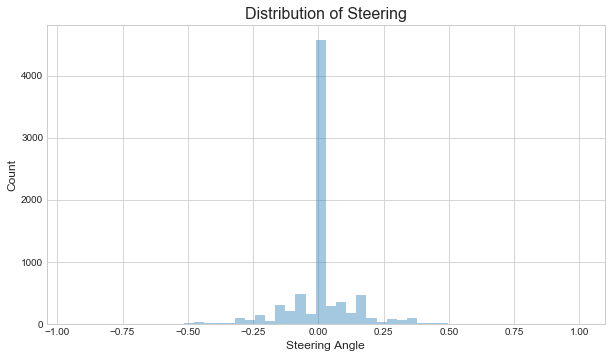

Counts for steering angle < 0.005: 4452


In [3]:
# plot the steering angles

plt.figure(figsize=(10,5.5))
ax = sns.distplot(data['steering'], kde=False)
ax.set_title('Distribution of Steering', fontsize=16)
ax.set_xlabel('Steering Angle', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

nsmall = np.sum(np.abs(data['steering']) < 0.005)
print ("Counts for steering angle < 0.005:", nsmall)

### Observation

It seems there are way too many data with steering angle close to zero, while other bins have at most 500 counts.

In order to have a balanced dataset, we can use the left/right camera and add additional angle offsets.
Moreover, we add more samples for large angles or filter out some data of small angles.
Since it it somewhat difficult to use a keyboard to generate useful data using the simulator, I choose to filter out some small angles.
Moreover, because the training data should reflect the same distribution to real use, I only screen out 10 % of data with angles smaller than 0.001.

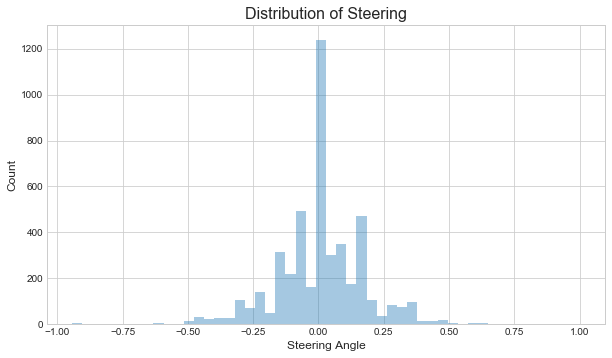

In [4]:
# select 25 % images of small steering angle
small_steering_idx = np.argwhere(np.abs(data['steering']) < 0.005).flatten()
keep_idx = np.random.choice(small_steering_idx, int(nsmall * 0.25))

keep_idx = np.append(keep_idx, np.argwhere(np.abs(data['steering']) >= 0.005).flatten())
new_data = {}
for name in data.columns:
    new_data[name] = np.array(data[name][keep_idx])

plt.figure(figsize=(10,5.5))
ax = sns.distplot(new_data['steering'], kde=False)
ax.set_title('Distribution of Steering', fontsize=16)
ax.set_xlabel('Steering Angle', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

In [5]:
# read and show images

def read_image(path, method='mpl'):
    """ Read an image from path and return the image. """
    
    if 'cv' in method or 'CV' in method:
        return cv2.imread(path)
    else:
        return mpimg.imread(path)

def show_image(image, title='image', method='mpl', fig_size=(8,4)):
    """ Show an image. """
    
    if 'cv' in method or 'CV' in method:
        cv2.imshow('image',img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        fig, ax = plt.subplots(figsize=fig_size)
        ax.imshow(image)
        ax.set_title(title)
        plt.show()
    return

def join_path(path):
    """ Add 'data/' befor path. """
    
    return '/'.join(['data', '/'.join(path.strip().split('/'))])
    
def read_image_triplet_new_data(i):
    """ Read and return the left, center, right images from index i in new_data. """
    
    out = []
    for angle in ['left', 'center', 'right']:
        path = join_path(new_data[angle][i])
        out.append(read_image(path))
    
    return out, new_data['steering'][i]

def show_image_triplet(image_triplet, steering):
    """ Show the left, center, right images. """
    
    titles = ['Left', 'Center', 'Right']
    
    print ("=> Steering Angle {:.2f} <=".format(steering))
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15, 2.5))
    for i in range(3):
        axes[i].imshow(image_triplet[i])
        
        axes[i].set_title(titles[i])
#         axes[i].grid(False)
        
        axes[i].set_xlim([0, 320])
        axes[i].set_xticks(range(0,350,50))
        
        axes[i].set_ylim([160, 0])
        axes[i].set_yticks(range(0,200,25))
    
    plt.show()
    return

def read_show_image_triplet_new_data(i):
    """ Read and show left, center, right images of index i in new_data. """
    
    image_triplet, steering_angle = read_image_triplet_new_data(i)
    show_image_triplet(image_triplet, steering_angle)
    return

=> Steering Angle 1.00 <=


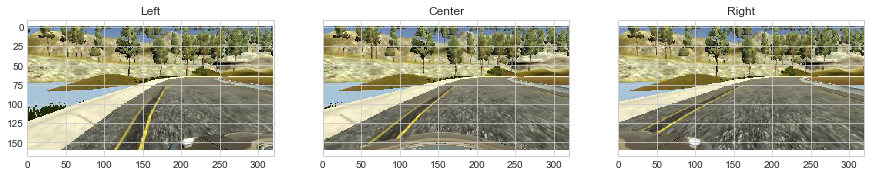

=> Steering Angle -0.94 <=


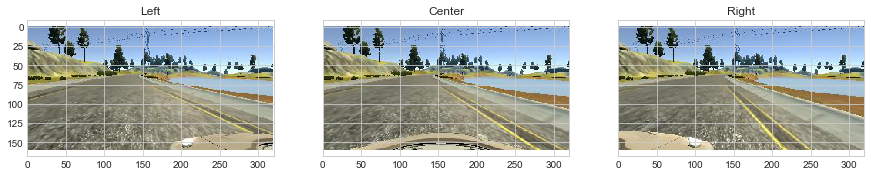

=> Steering Angle 0.00 <=


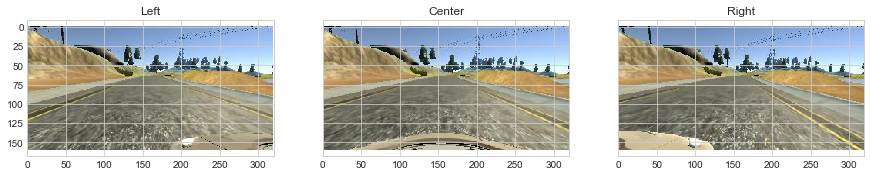

=> Steering Angle 0.00 <=


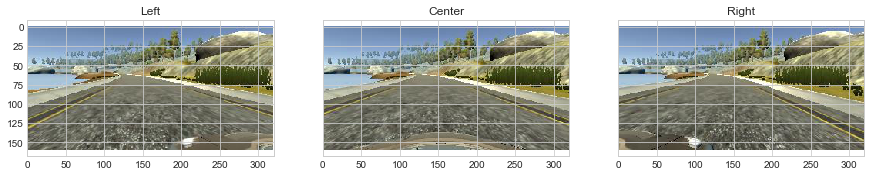

=> Steering Angle 0.00 <=


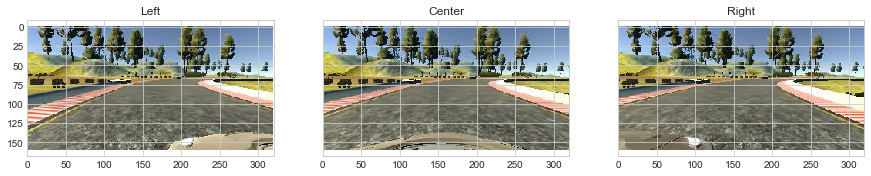

In [6]:
# find the most extreme case
imax = new_data['steering'].argmax()
read_show_image_triplet_new_data(imax)

imin = new_data['steering'].argmin()
read_show_image_triplet_new_data(imin)

# some zero angles
for i in np.random.choice(range(1113), 3):
    read_show_image_triplet_new_data(i)

### Observation

It seems the lower 25 pixels contains the hood and the upper 65 pixels are mainly the sky. I thus crop them out using `OpenCV`.

In [7]:
def crop_image_row(image, upper=65, lower=-25):
    """ Crop the rows of an image. """
    
    return image[upper:lower]

def crop_images_row(images, upper=65, lower=-25):
    """ Crop the rows of multiple images. """
    
    return images[:, upper:lower, :, :]

def change_brightness(image, offsets=(-0.35, 0.10)):
    """ Changes the brightness of an RGB image. """
    
    low, high = offsets
    transformer = 1.0 + np.random.uniform(low, high)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hs = hsv[:,:,2] * transformer
    hs[hs > 255] = 255
    hsv[:,:,2] = hs
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def flip_image(image, steering):
    """ Flip an image vertically. """
    
    return cv2.flip(image, 1), -steering

def RGB2YUV(image):
    """ Convert an RGB image to YUV color space. """
    
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

def gaussian_blur(image):
    """ Apply Gaussian blur to image. """
    
    return cv2.GaussianBlur(image, (3,3), 0)

def resize_image(image, width=200, height=66):
    """ Resize an image. """
    
    return cv2.resize(image, (width, height), cv2.INTER_AREA)

Image shape: (160, 320, 3) 

=> Original <=


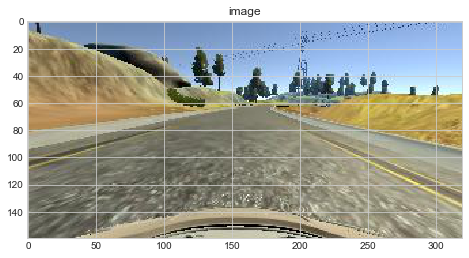

=> Crop <=


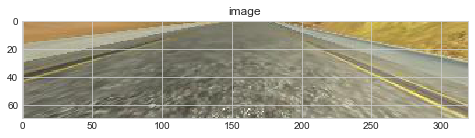

=> Change Brightness <=


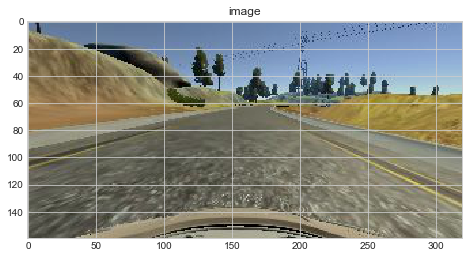

=> Flip Vertically <=


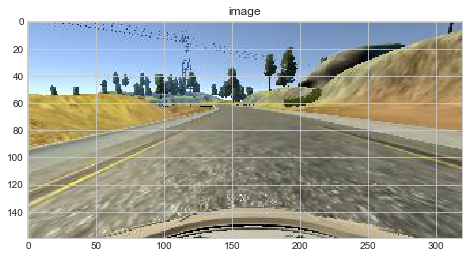

=> RGB to YUV <=


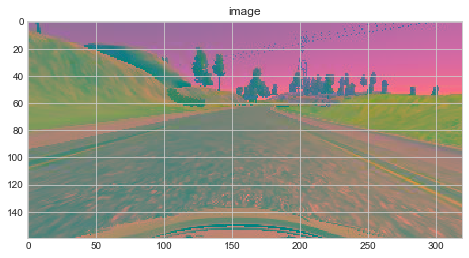

=> Gaussian Blur <=


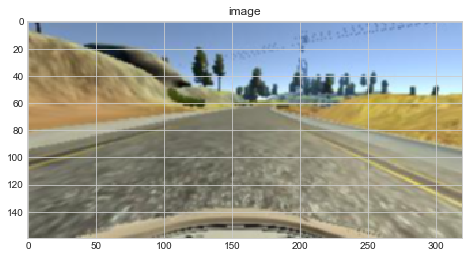

=> Resize <=


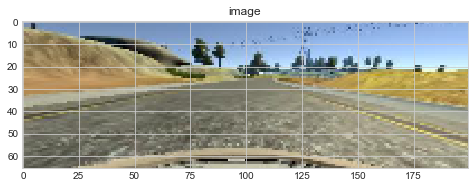

In [8]:
# test on image 0
image = read_image(join_path(new_data['center'][0]))
print ("Image shape:", image.shape, "\n")

print ("=> Original <=")
show_image(image)

print ("=> Crop <=")
show_image(crop_image_row(image))

print ("=> Change Brightness <=")
show_image(change_brightness(image))

print ("=> Flip Vertically <=")
show_image(flip_image(image, 0.0)[0])

print ("=> RGB to YUV <=")
show_image(RGB2YUV(image))

print ("=> Gaussian Blur <=")
show_image(gaussian_blur(image))

print ("=> Resize <=")
show_image(resize_image(image))

In [9]:
import sklearn

def augment_image(data, data_index, camera='random'):
    camera_angles = ['left', 'center', 'right']
    if camera not in camera_angles:
        p = np.random.choice(3)
        camera = camera_angles[p]
    
    steering_angle = data['steering'][data_index]
    if camera != 'center':
        random_corr = np.random.randint(18, 22) * 0.1
        steering_angle += random_corr if camera == 'left' else -random_corr
    
    image = read_image(join_path(data[camera][data_index]))
    
    if np.random.rand() < 0.5:
        image, steering_angle = flip_image(image, steering_angle)
    
    if np.random.rand() < 0.5:
        image = change_brightness(image)
    
    return image, steering_angle

def generator(data, data_indices, batch_size, train_mode=True, image_shape=(160,320,3)):
    ndata = len(data_indices)
    nrow, ncol, nch = image_shape
    
    images = np.zeros((batch_size, nrow, ncol, nch))
    steering_angles = np.zeros((batch_size, 1))
    
    def append_image_angle(image, angle, n):
        images[n] = image
        steering_angles[n] = angle
    
    def default_append(i, n):
        image = read_image(join_path(data['center'][i]))
        append_image_angle(image, data['steering'][i], n)
    
    while True:
        indices = np.random.choice(data_indices, batch_size)
        
        for n in range(batch_size):
            idx = indices[n]
            if train_mode and (np.random.rand() < 0.5):
                image, steering_angle = augment_image(data, idx)
                append_image_angle(image, steering_angle, n)
            else:
                default_append(i, n)
            
        X = np.array(images)
        y = np.array(steering_angles)
        
        yield sklearn.utils.shuffle(X, y)

In [10]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Lambda, Cropping2D, Conv2D, Dropout, Dense, Flatten

def model_NVIDIA( image_shape=(160,320,3), drop_prob=0.5, crop_row=(70,25) ):
    """ Modified NVIDIA model. """
    
    nrow, ncol, nch = image_shape
    feed_width, feed_height = 200, 66
    input_shape = (feed_height, feed_width, nch)
    
    model = Sequential()
    
    # cropping layer
    model.add(Cropping2D(cropping=(crop_row, (0, 0)), input_shape=image_shape))
    
    # lambda layer for resizing
    model.add(Lambda(lambda x: tf.image.resize_images(x, (feed_height, feed_width))))
    
    # lambda layer for normalization
    model.add(Lambda(lambda x: x / 255.0, input_shape=input_shape))
    
    # change color space to HSV
    model.add(Lambda(lambda x: tf.image.rgb_to_hsv(x), input_shape=input_shape))
    
    # convolution layers
    model.add(Conv2D(24, 5, strides=2, padding='same',
                     activation='relu', kernel_initializer='he_uniform', name='conv1'))
    
    model.add(Conv2D(36, 5, strides=2, padding='same',
                     activation='relu', kernel_initializer='he_uniform', name='conv2'))
    
    model.add(Conv2D(48, 5, strides=2, padding='valid',
                     activation='relu', kernel_initializer='he_uniform', name='conv3'))
    
    model.add(Conv2D(64, 3, strides=1, padding='valid',
                     activation='relu', kernel_initializer='he_uniform', name='conv4'))
    
    model.add(Conv2D(64, 3, strides=1, padding='valid',
                     activation='relu', kernel_initializer='he_uniform', name='conv5'))
    
    model.add(Conv2D(80, 3, strides=1, padding='valid',
                     activation='relu', kernel_initializer='he_uniform', name='conv6'))
    
    # flatten
    model.add(Flatten())
    
    # apply drop out
    model.add(Dropout(drop_prob))
    
    # fully connected layers
    model.add(Dense(100, activation='relu', name='fc1'))
    
    model.add(Dense(50, activation='relu', name='fc2'))
    
    model.add(Dense(10, activation='relu', name='fc3'))
    
    # output layer
    model.add(Dense(1, name='out'))
    
    return model

Using TensorFlow backend.


In [11]:
from keras.optimizers import Adam

def train_model(model, data, train_indices, valid_indices,
                learning_rate=0.001, decay_rate=0.01,
                batch_size=32, epochs=3, samples_per_epoch=64,
                validation_steps=64):
    """ Train the model. """
    
    # Adam optimizer
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate, decay=decay_rate))
    
    # train
    model.fit_generator(generator(data, train_indices, batch_size, train_mode=True),
                        samples_per_epoch, epochs,
                        validation_data=generator(data, valid_indices, batch_size, train_mode=False),
                        validation_steps=validation_steps, verbose=1, max_q_size=1)
    
    return

In [12]:
# number of data point (each point contains an image triplet -- left, center, right)
N = len(new_data['steering'])

# split data set
from sklearn.model_selection import train_test_split
train_indices, valid_indices = train_test_split(range(N), test_size=0.2)


model = model_NVIDIA()
train_model(model, new_data, train_indices, valid_indices, batch_size=16,
            samples_per_epoch=50, validation_steps=25)

/Users/york/src/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 50, 3, validation_steps=25, verbose=1, max_queue_size=1, validation_data=<generator...)`
  app.launch_new_instance()


Epoch 1/3
50/50 [==============================] - 16s 314ms/step - loss: 1.2062 - val_loss: 0.0012
Epoch 2/3
50/50 [==============================] - 17s 337ms/step - loss: 1.0134 - val_loss: 0.1688
Epoch 3/3
50/50 [==============================] - 17s 332ms/step - loss: 0.7292 - val_loss: 0.0048


In [13]:
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 33, 100, 24)       1824      
_________________________________________________________________
conv2 (Conv2D)               (None, 17, 50, 36)        21636     
_________________________________________________________________
conv3 (Conv2D)               (None, 7, 23, 48)         43248     
__________

In [14]:
model.save('model_test.h5')

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

plot_model(model, to_file='model.png', show_shapes=True)
# SVG(model_to_dot(model).create(prog='dot', format='svg'))